In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import os

## Load Data

In [8]:
labels = ["Opaque", "Red", "Green", "Yellow", "Bright", "Light-blue", "Colors", "Red", "Women", "Enemy", "Son", "Man", "Away", "Drawer", "Born", "Learn",
          "Call", "Skimmer", "Bitter", "Sweet milk", "Milk", "Water", "Food", "Argentina", "Uruguay", "Country", "Last name", "Where", "Mock", "Birthday", "Breakfast", "Photo",
          "Hungry", "Map", "Coin", "Music", "Ship", "None", "Name", "Patience", "Perfume", "Deaf", "Trap", "Rice", "Barbecue", "Candy", "Chewing-gum", "Spaghetti",
          "Yogurt", "Accept", "Thanks", "Shut down", "Appear", "To land", "Catch", "Help", "Dance", "Bathe", "Buy", "Copy", "Run", "Realize", "Give", "Find"]

data_dir = os.path.join(os.getcwd(), 'dataset', 'npz')
datasets = os.listdir(data_dir)
selected_frames = 16

In [9]:
X, y = [], []

for filename in datasets:
    content = np.load(os.path.join(data_dir, filename))
    length = content['x'].shape[0]
    if length < selected_frames:
        continue
    selected = content['y'][np.linspace(0, length-1, selected_frames).astype(int)]
    # x = [line.flatten() for line in selected]
    X.append(np.array(selected, dtype='float32'))
    y.append(int(filename.split('_')[0])-1)

X = np.array(X, dtype='float32')
y = np.array(y, dtype='uint8')
y = to_categorical(y).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [129]:
X_train.shape, y_train.shape
print(y_train[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
ERROR! Session/line number was not unique in database. History logging moved to new session 150


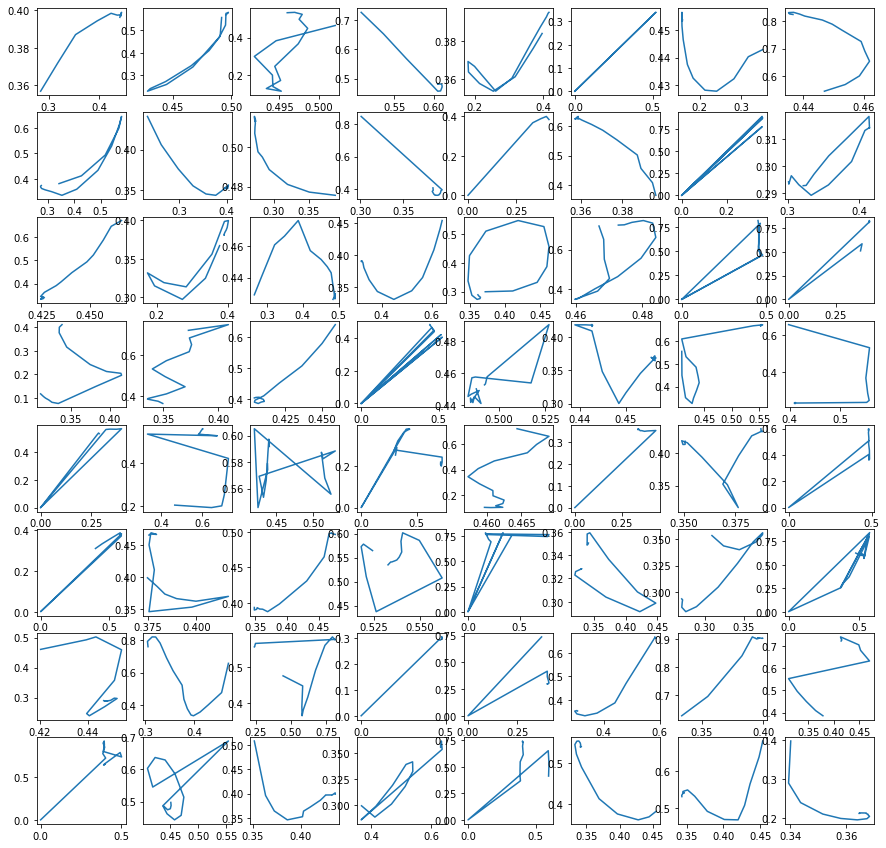

In [176]:
import matplotlib.pyplot as plt
%matplotlib inline
#矢量图,64个手势
def draw_vector(key):#key值-[0,74]代表不同的位点
    x,y=[],[]
    plt.figure(figsize=(15,15))
    for m in range(64):
        plt.subplot(8,8,m+1)
        for i in range(X_train.shape[0]):
            if y_train[i][m]==1:
                for j in range(X_train.shape[1]):
                    x.append(X_train[i][j][key][0])
                    y.append(X_train[i][j][key][1])
            if len(x)!=0:
                break
        plt.plot(x,y)
        x,y=[],[]
draw_vector(38)
# print(y)
# plt.figure(figsize=(3,3))
# plt.scatter(x,y,s=10)

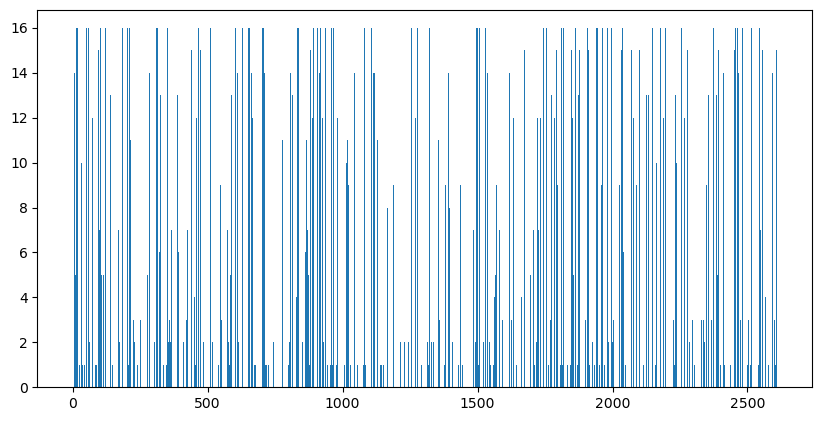

In [168]:
def data_set_feature(x):#x代表位点
    cnt,index=[],[]
    for i in range(X_train.shape[0]):
        tmp=0
        index.append(i)
        for k in range(X_train.shape[1]):
            #for m in range(X_train.shape[2])
            if X_train[i][k][x][0]!=0 and X_train[i][k][0][1]!=0:
                tmp+=1
        cnt.append(tmp)
    plt.figure(figsize=(10,5),dpi=100)
    plt.bar(index,cnt)
    #print(cnt)
data_set_feature(70)

In [6]:
log_dir = "./logs/"
callback = TensorBoard(log_dir)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## STDN

In [7]:
def stdn(att_lstm_num, att_lstm_seq_len, lstm_seq_len, feature_vec_len, cnn_flat_size = 128, lstm_out_size = 128, nbhd_size = 3, 
         nbhd_type = 2, map_x_num = 10, map_y_num = 20, flow_type = 4, output_shape = 2, optimizer = 'adagrad', loss = 'mse', metrics=[]):

        flatten_att_nbhd_inputs = [Input(shape = (nbhd_size, nbhd_size, nbhd_type,), name = "att_nbhd_volume_input_time_{0}_{1}".format(att+1, ts+1)) for ts in range(att_lstm_seq_len) for att in range(att_lstm_num)]
        flatten_att_flow_inputs = [Input(shape = (nbhd_size, nbhd_size, flow_type,), name = "att_flow_volume_input_time_{0}_{1}".format(att+1, ts+1)) for ts in range(att_lstm_seq_len) for att in range(att_lstm_num)]

        att_nbhd_inputs = []
        att_flow_inputs = []
        for att in range(att_lstm_num):
            att_nbhd_inputs.append(flatten_att_nbhd_inputs[att*att_lstm_seq_len:(att+1)*att_lstm_seq_len])
            att_flow_inputs.append(flatten_att_flow_inputs[att*att_lstm_seq_len:(att+1)*att_lstm_seq_len])

        att_lstm_inputs = [Input(shape = (att_lstm_seq_len, feature_vec_len,), name = "att_lstm_input_{0}".format(att+1)) for att in range(att_lstm_num)]
        nbhd_inputs = [Input(shape = (nbhd_size, nbhd_size, nbhd_type,), name = "nbhd_volume_input_time_{0}".format(ts+1)) for ts in range(lstm_seq_len)]
        flow_inputs = [Input(shape = (nbhd_size, nbhd_size, flow_type,), name = "flow_volume_input_time_{0}".format(ts+1)) for ts in range(lstm_seq_len)]
        lstm_inputs = Input(shape = (lstm_seq_len, feature_vec_len,), name = "lstm_input")

        #short-term part
        #1st level gate
        #nbhd cnn
        nbhd_convs = [Conv2D(filters = 64, kernel_size = (3,3), padding="same", name = "nbhd_convs_time0_{0}".format(ts+1))(nbhd_inputs[ts]) for ts in range(lstm_seq_len)]
        nbhd_convs = [Activation("relu", name = "nbhd_convs_activation_time0_{0}".format(ts+1))(nbhd_convs[ts]) for ts in range(lstm_seq_len)]
        #flow cnn
        flow_convs = [Conv2D(filters = 64, kernel_size = (3,3), padding="same", name = "flow_convs_time0_{0}".format(ts+1))(flow_inputs[ts]) for ts in range(lstm_seq_len)]
        flow_convs = [Activation("relu", name = "flow_convs_activation_time0_{0}".format(ts+1))(flow_convs[ts]) for ts in range(lstm_seq_len)]
        #flow gate
        flow_gates = [Activation("sigmoid", name = "flow_gate0_{0}".format(ts+1))(flow_convs[ts]) for ts in range(lstm_seq_len)]
        nbhd_convs = [keras.layers.Multiply()([nbhd_convs[ts], flow_gates[ts]]) for ts in range(lstm_seq_len)]


        #2nd level gate
        nbhd_convs = [Conv2D(filters = 64, kernel_size = (3,3), padding="same", name = "nbhd_convs_time1_{0}".format(ts+1))(nbhd_convs[ts]) for ts in range(lstm_seq_len)]
        nbhd_convs = [Activation("relu", name = "nbhd_convs_activation_time1_{0}".format(ts+1))(nbhd_convs[ts]) for ts in range(lstm_seq_len)]
        flow_convs = [Conv2D(filters = 64, kernel_size = (3,3), padding="same", name = "flow_convs_time1_{0}".format(ts+1))(flow_inputs[ts]) for ts in range(lstm_seq_len)]
        flow_convs = [Activation("relu", name = "flow_convs_activation_time1_{0}".format(ts+1))(flow_convs[ts]) for ts in range(lstm_seq_len)]
        flow_gates = [Activation("sigmoid", name = "flow_gate1_{0}".format(ts+1))(flow_convs[ts]) for ts in range(lstm_seq_len)]
        nbhd_convs = [keras.layers.Multiply()([nbhd_convs[ts], flow_gates[ts]]) for ts in range(lstm_seq_len)]

        #3rd level gate
        nbhd_convs = [Conv2D(filters = 64, kernel_size = (3,3), padding="same", name = "nbhd_convs_time2_{0}".format(ts+1))(nbhd_convs[ts]) for ts in range(lstm_seq_len)]
        nbhd_convs = [Activation("relu", name = "nbhd_convs_activation_time2_{0}".format(ts+1))(nbhd_convs[ts]) for ts in range(lstm_seq_len)]
        flow_convs = [Conv2D(filters = 64, kernel_size = (3,3), padding="same", name = "flow_convs_time2_{0}".format(ts+1))(flow_inputs[ts]) for ts in range(lstm_seq_len)]
        flow_convs = [Activation("relu", name = "flow_convs_activation_time2_{0}".format(ts+1))(flow_convs[ts]) for ts in range(lstm_seq_len)]
        flow_gates = [Activation("sigmoid", name = "flow_gate2_{0}".format(ts+1))(flow_convs[ts]) for ts in range(lstm_seq_len)]
        nbhd_convs = [keras.layers.Multiply()([nbhd_convs[ts], flow_gates[ts]]) for ts in range(lstm_seq_len)]


        #dense part
        nbhd_vecs = [Flatten(name = "nbhd_flatten_time_{0}".format(ts+1))(nbhd_convs[ts]) for ts in range(lstm_seq_len)]
        nbhd_vecs = [Dense(units = cnn_flat_size, name = "nbhd_dense_time_{0}".format(ts+1))(nbhd_vecs[ts]) for ts in range(lstm_seq_len)]
        nbhd_vecs = [Activation("relu", name = "nbhd_dense_activation_time_{0}".format(ts+1))(nbhd_vecs[ts]) for ts in range(lstm_seq_len)]

        #feature concatenate
        nbhd_vec = Concatenate(axis=-1)(nbhd_vecs)
        nbhd_vec = Reshape(target_shape = (lstm_seq_len, cnn_flat_size))(nbhd_vec)
        lstm_input = Concatenate(axis=-1)([lstm_inputs, nbhd_vec])

        #lstm
        lstm = LSTM(units=lstm_out_size, return_sequences=False, dropout=0.1, recurrent_dropout=0.1)(lstm_input)

        #attention part
        att_nbhd_convs = [[Conv2D(filters = 64, kernel_size = (3,3), padding="same", name = "att_nbhd_convs_time0_{0}_{1}".format(att+1,ts+1))(att_nbhd_inputs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_nbhd_convs = [[Activation("relu", name = "att_nbhd_convs_activation_time0_{0}_{1}".format(att+1,ts+1))(att_nbhd_convs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_flow_convs = [[Conv2D(filters = 64, kernel_size = (3,3), padding="same", name = "att_flow_convs_time0_{0}_{1}".format(att+1,ts+1))(att_flow_inputs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_flow_convs = [[Activation("relu", name = "att_flow_convs_activation_time0_{0}_{1}".format(att+1,ts+1))(att_flow_convs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_flow_gates = [[Activation("sigmoid", name = "att_flow_gate0_{0}_{1}".format(att+1, ts+1))(att_flow_convs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_nbhd_convs = [[keras.layers.Multiply()([att_nbhd_convs[att][ts], att_flow_gates[att][ts]]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]

        att_nbhd_convs = [[Conv2D(filters = 64, kernel_size = (3,3), padding="same", name = "att_nbhd_convs_time1_{0}_{1}".format(att+1,ts+1))(att_nbhd_convs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_nbhd_convs = [[Activation("relu", name = "att_nbhd_convs_activation_time1_{0}_{1}".format(att+1,ts+1))(att_nbhd_convs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_flow_convs = [[Conv2D(filters = 64, kernel_size = (3,3), padding="same", name = "att_flow_convs_time1_{0}_{1}".format(att+1,ts+1))(att_flow_convs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_flow_convs = [[Activation("relu", name = "att_flow_convs_activation_time1_{0}_{1}".format(att+1,ts+1))(att_flow_convs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_flow_gates = [[Activation("sigmoid", name = "att_flow_gate1_{0}_{1}".format(att+1, ts+1))(att_flow_convs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_nbhd_convs = [[keras.layers.Multiply()([att_nbhd_convs[att][ts], att_flow_gates[att][ts]]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]

        att_nbhd_convs = [[Conv2D(filters = 64, kernel_size = (3,3), padding="same", name = "att_nbhd_convs_time2_{0}_{1}".format(att+1,ts+1))(att_nbhd_convs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_nbhd_convs = [[Activation("relu", name = "att_nbhd_convs_activation_time2_{0}_{1}".format(att+1,ts+1))(att_nbhd_convs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_flow_convs = [[Conv2D(filters = 64, kernel_size = (3,3), padding="same", name = "att_flow_convs_time2_{0}_{1}".format(att+1,ts+1))(att_flow_convs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_flow_convs = [[Activation("relu", name = "att_flow_convs_activation_time2_{0}_{1}".format(att+1,ts+1))(att_flow_convs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_flow_gates = [[Activation("sigmoid", name = "att_flow_gate2_{0}_{1}".format(att+1, ts+1))(att_flow_convs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_nbhd_convs = [[keras.layers.Multiply()([att_nbhd_convs[att][ts], att_flow_gates[att][ts]]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]

        att_nbhd_vecs = [[Flatten(name = "att_nbhd_flatten_time_{0}_{1}".format(att+1,ts+1))(att_nbhd_convs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_nbhd_vecs = [[Dense(units = cnn_flat_size, name = "att_nbhd_dense_time_{0}_{1}".format(att+1,ts+1))(att_nbhd_vecs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]
        att_nbhd_vecs = [[Activation("relu", name = "att_nbhd_dense_activation_time_{0}_{1}".format(att+1,ts+1))(att_nbhd_vecs[att][ts]) for ts in range(att_lstm_seq_len)] for att in range(att_lstm_num)]


        att_nbhd_vec = [Concatenate(axis=-1)(att_nbhd_vecs[att]) for att in range(att_lstm_num)]
        att_nbhd_vec = [Reshape(target_shape = (att_lstm_seq_len, cnn_flat_size))(att_nbhd_vec[att]) for att in range(att_lstm_num)]
        att_lstm_input = [Concatenate(axis=-1)([att_lstm_inputs[att], att_nbhd_vec[att]]) for att in range(att_lstm_num)]

        att_lstms = [LSTM(units=lstm_out_size, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, name="att_lstm_{0}".format(att + 1))(att_lstm_input[att]) for att in range(att_lstm_num)]

        #compare
        att_low_level=[attention.Attention(method='cba')([att_lstms[att], lstm]) for att in range(att_lstm_num)]
        att_low_level=Concatenate(axis=-1)(att_low_level)
        att_low_level=Reshape(target_shape=(att_lstm_num, lstm_out_size))(att_low_level)


        att_high_level = LSTM(units=lstm_out_size, return_sequences=False, dropout=0.1, recurrent_dropout=0.1)(att_low_level)

        lstm_all = Concatenate(axis=-1)([att_high_level, lstm])
        # lstm_all = Dropout(rate = .3)(lstm_all)
        lstm_all = Dense(units = output_shape)(lstm_all)
        pred_volume = Activation('tanh')(lstm_all)

        inputs = flatten_att_nbhd_inputs + flatten_att_flow_inputs + att_lstm_inputs + nbhd_inputs + flow_inputs + [lstm_inputs,]
        # print("Model input length: {0}".format(len(inputs)))
        model = Model(inputs = inputs, outputs = pred_volume)
        model.compile(optimizer = optimizer, loss = loss, metrics=metrics)
        return model

## Model

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
 
# softmax classifier
model.add(Dense(y_train.shape[1]))
model.add(Activation("softmax"))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
model.fit(X_train, y_train, epochs=40)

Train on 2611 samples
Epoch 1/40
2611/2611 [==============================] - 11s 4ms/sample - loss: 4.2621 - accuracy: 0.1042
Epoch 2/40
2611/2611 [==============================] - 10s 4ms/sample - loss: 2.6349 - accuracy: 0.2876
Epoch 3/40
2611/2611 [==============================] - 8s 3ms/sample - loss: 1.8789 - accuracy: 0.4366
Epoch 4/40
2611/2611 [==============================] - 9s 3ms/sample - loss: 1.4659 - accuracy: 0.5481
Epoch 5/40
2611/2611 [==============================] - 8s 3ms/sample - loss: 1.1600 - accuracy: 0.6377
Epoch 6/40
2611/2611 [==============================] - 8s 3ms/sample - loss: 1.0064 - accuracy: 0.6794
Epoch 7/40
 768/2611 [=======>......................] - ETA: 5s - loss: 0.8273 - accuracy: 0.7188

In [ ]:
model.save("model/VGGNet15")

In [ ]:
model = keras.models.load_model("model/VGGNet-mini")

In [ ]:
p = model.predict(X_test)

In [ ]:
np.argmax(p, axis=1) - np.argmax(y_test, axis=1)

In [ ]:
model = Sequential(
    Input(shape=X_test.shape[1:]),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    
    
)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='mae', metrics=['categorical_accuracy'])

"""
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
"""

In [ ]:
model.fit(X_train, y_train, epochs=20)#, callbacks=[callback]

In [ ]:
y_predict = model.predict(X_test)

In [ ]:
np.argmax(y_predict, axis=1)